1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Face Detected! Probability: 99.99%


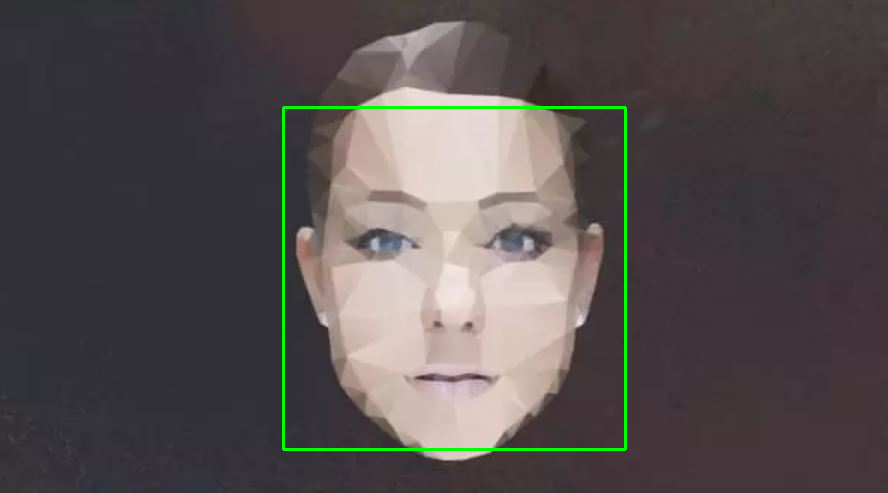

In [1]:
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Activation, Flatten
from google.colab.patches import cv2_imshow

# Load the pre-trained model (ResNet50) with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top of the base model
x = base_model.output
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)  # ReLU activation after convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers so that we only train the custom layers
for layer in base_model.layers:
    layer.trainable = False

# Step 1: Load the face detection model (Haar Cascade Classifier)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Step 2: Load and preprocess the image
image_path = '/content/Face.JPG'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 3: Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# If faces are detected
if len(faces) > 0:
    for (x, y, w, h) in faces:
        # Crop the face region from the image
        face = img[y:y+h, x:x+w]

        # Resize the face region to match ResNet50 input size (224x224)
        face_resized = cv2.resize(face, (224, 224))

        # Convert the image from BGR to RGB
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

        # Normalize the image (ResNet50 preprocessing)
        face_normalized = preprocess_input(np.expand_dims(face_rgb, axis=0))

        # Step 4: Make a prediction using the model
        prediction = model.predict(face_normalized)

        # Step 5: Output the result
        probability = prediction[0][0]
        if probability > 0.5:
            print(f"Face Detected! Probability: {probability * 100:.2f}%")
        else:
            print(f"No Face Detected. Probability: {(1 - probability) * 100:.2f}%")

        # Draw rectangle around the face
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
else:
    print("No faces found.")

# Display the result
cv2_imshow(img)
